In [1]:
import scipy
import scipy.optimize as scopt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import eosHSG as eos
from NRTL import NRTL

from NRTL import NRTL
from PureComponentData import purecomponentdata

In [2]:
water = purecomponentdata.Compound("Water")
ipa = purecomponentdata.Compound("2-Propanol")
dict_compounds = {"water":water, "ipa":ipa}

In [3]:
nrtl = NRTL.NRTL(["ipa","water"])

In [4]:
nrtl.populate_matrix('A', {'ipa-water': [-0.53745742088997905, 3.0540162490081966]})
nrtl.populate_matrix('alpha',{'ipa-water': [0.20000000000000001, 0.20000000000000001]})

In [5]:
nrtl.yield_parameters()

{'A': {'ipa-water': [-0.537457420889979, 3.0540162490081966]},
 'B': {'ipa-water': [0.0, 0.0]},
 'C': {'ipa-water': [0.0, 0.0]},
 'D': {'ipa-water': [0.0, 0.0]},
 'alpha': {'ipa-water': [0.2, 0.2]}}

In [6]:
nrtl.dict_component_index

{'ipa': 0, 'water': 1}

## Getting Bubble Point and Dew Point

## Bubble Point
We now need to determine the temperature at which the first bubble appears
$$
        P_{Total} = \sum_{i=1}^{N} \gamma_i x_i P_i^{sat}(T)
$$

In [7]:
def get_residual_bubblepoint(T, dict_molfractions, nrtl, Ptotal):
    dict_gammas = nrtl.get_gammas(T, dict_molfractions)
    P = 0.0
    for name in dict_molfractions:
        P += dict_gammas[name]*dict_molfractions[name]*dict_compounds[name].Pvap(T)
    return Ptotal - P

def get_bubble_point(Ptotal, dict_molfractions):    
    Tbubble = scopt.newton(get_residual_bubblepoint, 300.0, args = (dict_molfractions, nrtl, Ptotal))
    return Tbubble


    

In [8]:
dict_molfractions = {"water":1-0.682, "ipa":0.682}
Ptotal = 1.013e5 #Pa
get_bubble_point(Ptotal, dict_molfractions)-273.16

80.14462052683132

## Dew Point
We now need to determine the temperature at which the final drop disappears.  We have
$$
            P_{Total}y_i = \gamma_i x_i P_i^{sat}(T)
$$
We have to solve:
$$
            \sum_{i=1}^N \frac{P_{Total}y_i}{\gamma_i P_i^{sat}(T)} = 1
$$


In [9]:
def get_residual_dewpoint(T, dict_molfractionsV, dict_molfractionsL, nrtl, Ptotal):
    gammas = nrtl.get_gammas(T, dict_molfractionsL)
    summ = 0.0
    for name in dict_molfractionsL:
        s = Ptotal * dict_molfractionsV[name] / gammas[name] / dict_compounds[name].Pvap(T)
        summ += s
    return summ - 1

def get_dew_point(Ptotal, dict_molfractions):
    bool_go = True
    dict_molfractionsL = dict_molfractions.copy()
    dict_molfractionsV = dict_molfractions.copy()
    Told = 300.0
    while bool_go:
        T = scopt.newton(get_residual_dewpoint, Told, args=(dict_molfractionsV, dict_molfractionsL, nrtl, Ptotal))
        gammas = nrtl.get_gammas(T, dict_molfractionsL)
        sumx = 0.0
        for name in dict_molfractionsV:
            x = Ptotal * dict_molfractionsV[name] / gammas[name] / dict_compounds[name].Pvap(T)
            dict_molfractionsL[name] = x
            sumx += x
        for name in dict_molfractionsL:
            dict_molfractionsL[name] /= sumx
        
        if abs(T - Told) < 0.1:
            bool_go = False
        else:
            Told = T + 0.0
    return T
        

In [10]:
dict_molfractions = {"water":1-0.682, "ipa":0.682}
Ptotal = 1.013e5 #Pa
get_dew_point(Ptotal, dict_molfractions)-273.16

80.16284819791167

# P-T Flash
We are given a stream with known $P_{Total}$, known $T$ and known composition $\{z_i\}$.  We want to know how this stream divides into a vapour and a liquid phase and what its resulting enthalpy is.  Let a fraction $\beta$ of the incoming stream vapourize.  Hence, $F = V + L = \beta F + (1-\beta)F$.  The component mole balance is:
$$
                Fz_i = Vy_i + Lx_i
$$
Equilibrium gives:
$$
                y_i = K_i x_i
$$
Substituting:
$$
                Fz_i = \beta F K_i x_i + (1-\beta) F x_i
$$
i.e. rearranging
$$
                x_i = \frac{z_i}{1 +\beta (K_i-1)}
$$
Hence,
$$
                y_i = K_i x_i = \frac{K_iz_i}{1 +\beta (K_i-1)}
$$
Since $\sum_{i=1}^N (y_i-x_i) = 0$, hence,
$$
              \sum_{i=1}^N\frac{(K_i-1)z_i}{1 +\beta (K_i-1)} = 0 
$$
This is the famous Rachford Rice Equation.

Let us call $S = \sum_{i=1}^N\frac{(K_i-1)z_i}{1 +\beta (K_i-1)}$.  Hence,
$$
    \frac{dS}{d\beta} = -\sum_{i=1}^N\frac{z_i(K_i-1)^2}{(1 +\beta (K_i-1))^2}
$$
This derivative is always negative!  i.e. Newton Raphson is always monotonous.  We are guaranteed a solution of $\beta$.
Once we have a value of $\beta$, we can use it to find $x_i$ from:
$$
                x_i = \frac{z_i}{1 +\beta (K_i-1)}
$$
And we can get our new values of $K_i$.  And the iterations continue until we get no improvement in the value of $\beta$.
Note for low pressures and reasonably high temperatures:
$$
                K_i = \gamma_i P_i^{sat}/P_{Total}
$$

In [11]:
def get_K(T, P_total, dict_molfractions):
    gammas = nrtl.get_gammas(T, dict_molfractions)
    K = {}
    for name in gammas:
        K[name] = dict_compounds[name].Pvap(T)*gammas[name] / P_total
    return K
    
def residual_beta(beta, z, K):
    S = 0
    for name in z:
        S += (K[name] - 1)*z[name]/(1+beta*(K[name]-1))
    return S

def get_beta(z, K, betaguess = 0.5):
    beta = scopt.fsolve(residual_beta, betaguess, args = (z, K))
    return beta

def get_x(z, K, beta):
    x = {}
    for name in z:
        x[name] = z[name]/(1+beta*(K[name]-1))
    return x
    

In [12]:
Ptotal = 1.013e5 #Pa
T = 90 + 273.16 #K
F = 1.0 #kmol/s
dict_molfractions = {"water":0.7, "ipa":1-0.7}

In [13]:
def flash_PT(T, Ptotal, dict_molfractions):
    Tbubble = get_bubble_point(Ptotal, dict_molfractions)
    Tdew = get_dew_point(Ptotal, dict_molfractions)

    if T >= Tdew:
        beta = 1 
        x = 'junk'
        y = dict_molfractions.copy()
    elif T <= Tbubble:
        beta = 0
        y = 'junk'
        x = dict_molfractions.copy()
    else:
        betaguess = (T - Tbubble)/(Tdew - Tbubble)
        K = get_K(T, Ptotal, dict_molfractions) #starting guess of K
        bool_go = True
        while bool_go:
            beta = get_beta(dict_molfractions, K, betaguess = betaguess)
            x = get_x(dict_molfractions, K, beta)
            #print(beta, betaguess)
            if abs(beta - betaguess)/beta < 0.001:
                bool_go = False
            else:
                betaguess = beta + 0.0
                K = get_K(T, Ptotal, x) #update of K
        y = {}
        for name in x:
            y[name] = K[name]*x[name]
    return beta,x,y



In [14]:
flash_PT(T, Ptotal, dict_molfractions)

(array([0.91910203]),
 {'water': array([0.97288342]), 'ipa': array([0.02711658])},
 {'water': array([0.67598121]), 'ipa': array([0.32401879])})

# Homework
Use flash_PT to calculate the T-x-y diagram and compare with T-x-y diagram obtained from bubble point and dew point

In [15]:
x = np.linspace(0,1, 50)
Tdew = np.zeros(len(x))
Tbub = np.zeros(len(x))
Tflash = np.zeros(len(x))


Ptotal = 1.013e5 #Pa
for i in range(len(x)):
    dict_molfractions = {"ipa":x[i], "water":1-x[i]}
    
    Tbub[i] =  get_bubble_point(Ptotal, dict_molfractions)-273.16
    Tdew[i] =  get_dew_point(Ptotal, dict_molfractions)-273.16
    Tflash[i] = (Tdew[i] + Tbub[i])/2 + 273.16

In [16]:
bflash = np.linspace(0,1, 50)
xflash = np.linspace(0,1, 50)
yflash = np.linspace(0,1, 50)


c = 0 
for i in range(len(x)):
    dict_molfractions = {'ipa':x[i], 'water':1-x[i]}
    
    b,xf,yf = flash_PT(Tflash[i], Ptotal, dict_molfractions)
    if xf=='junk':
        xflash[i] = 0 
    elif yf=='junk':
        yflash[i] = 1
    else:
        
        bflash[i] = b ; xflash[i] = xf['ipa'] ; yflash[i] = yf['ipa']
    #print(b, xf, yf)
    c+=1

C:\Users\hp1\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\hp1\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


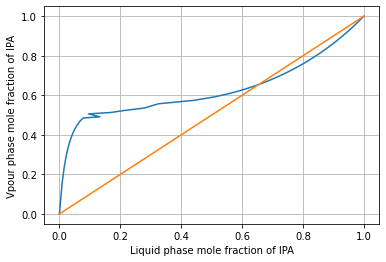

In [17]:
xflash[-1] = 1
yflash[-1] = 1
plt.plot(xflash ,yflash)
plt.plot([0,1], [0,1])
plt.xlabel("Liquid phase mole fraction of IPA")
plt.ylabel("Vpour phase mole fraction of IPA")
plt.grid()

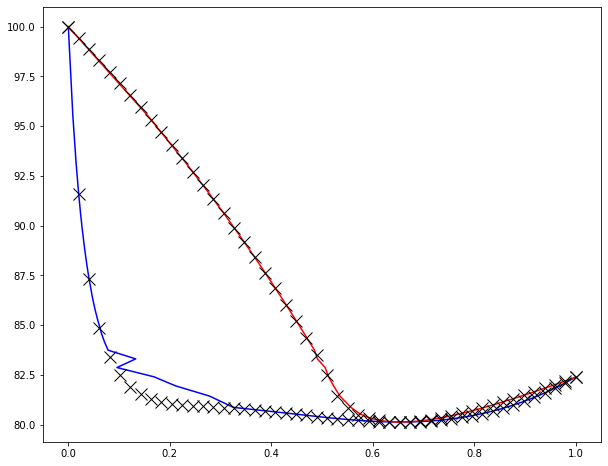

In [18]:
plt.figure(figsize = (10,8))
plt.plot(xflash, Tflash - 273.16, 'b', label = 'x')
plt.plot(yflash, Tflash - 273.16, 'r', label = 'y')
plt.plot(x, Tdew, 'kx', markersize = 12)
plt.plot(x, Tbub, 'kx', markersize = 12)